# Simulating a 2D image and error analysis using Sherpa UI and MCMC

This notebook shows an example on fitting with Sherpa through its UI convenience module.

The example is simple but it shows several interesting features of Sherpa. It perfectly corresponds to [its sister notebook](2D Simulated Image Fit with Astropy and MCMC.ipynb) showing off the Sherpa-Astropy integration.

In this notebook we:
  - simulate a 2D image of an astronomical source with two gaussian components, in Poisson noise regime;
  - fit the simulated data with a model, providing empirical guesses as initial parameter values;
  - calculate the posterior probability distributions of each model parameters using the MCMC Bayesian framework;
  - calculate and visualize diagnostics of the goodness of fit, including:
     - residuals;
     - a detailed graphical representation of all the paramters posterior probability distributions;
     - a detailed graphical representation of the covariance of the parameters;
     - a graphical comparison of the *true* values with the parameters posterior distributions.

## Initialize matplotlib

The following cell sets up `matplotlib`, the plotting package.

First, it makes sure the plots are visualized inside the notebook, which is best suited for a self-contained notebook, especially on the web. If you run the notebook from your own system, then you might choose to run `matplotlib` interactively in a desktop window.

Then, it imports the `matplotlib` module `pyplot`, which we will use in the notebook.

Finally, it sets up some global parameters that all plots will inherit, e.g. the colormap and the origin point for images we will display.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'cubehelix'
plt.rcParams['image.origin'] = 'lower'

## Import necessary dependencies

We will interact with Sherpa using the `sherpa.astro.ui` module, which provides many convenience methods for performing interactive analysis. Sherpa also offers an Object Oriented, low-level API that is more suitable for developers of external packages.

We also import the `Gauss2D` model and the `Data2D` class, which we'll need later. `Numpy` provides many data structures and methods for numerical processing, while the `corner` package will be used to display the posterior distributions of the model parameters at the end of this notebook.

In [2]:
from sherpa.astro import ui
from sherpa.models import SigmaGauss2D
from sherpa.astro.data import Data2D
import numpy as np
import corner

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


## Simulate an image in poissonian noise regime

The cell below simulates the image of an astronomical source.

By simulating the image we can compare the results of the fit with the actual values. For clarity and simplicity, the image is fairly simple, however with Sherpa it is possible to fit complex combination of model functions, simultaneuously fitting the background, and possibly including PSF information. The more complex the model, the longer it will take to get a good fit.

We use numpy to define a mesh-grid of image coordinates.

Then we define the source emission as having two Gaussian components with different parameters. Both components have the same center and no eccentricity.

Finally, we create a "perfect" source by evaluating the two models on the mesh-grid and adding them together.

We generate the actual simulated, noisy image by using numpy to draw a random number from poissonian distributions, each with an expectation value equal to the emission of the "perfect" source.

Note that the `Gauss2D` model from Sherpa and the `Gaussian2D` model from Astropy use slightly different parameters, as `Gauss2D` uses the Full-Width at Half-Maximum parameter, while `Gaussian2D` uses $\sigma$. As mentioned in the Sherpa documentation, fwhm and $\sigma$ are related through a constant factor. In order to compare the results from the fit with Astropy, we use this constant to express the initial values in the same units. 

In [3]:
np.random.seed(4)
x0lo, x0hi = 3000, 4000
x1lo, x1hi = 4000, 4800
dx = 5
x1, x0 = np.mgrid[x1lo:x1hi:dx, x0lo:x0hi:dx]
shape = x0.shape
x0 = x0.flatten()
x1 = x1.flatten()

source_one = SigmaGauss2D('src1')
source_one.xpos = 3561
source_one.ypos = 4482
source_one.ampl = 35
source_one.sigma_a = 50
source_one.sigma_b = 50

source_two = SigmaGauss2D('src2')
source_two.xpos = 3561
source_two.ypos = 4482
source_two.ampl = 10
source_two.sigma_a = 150
source_two.sigma_b = 150

source = source_one + source_two

mexp = source(x0, x1).reshape(shape)
image = np.random.poisson(mexp)

ui.load_arrays(1, x0, x1, image.flatten(), Data2D)

We use matplotlib to plot the simulated image.

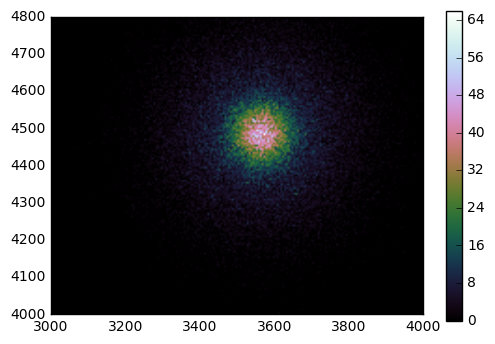

In [4]:
boundaries = (x0lo, x0hi, x1lo, x1hi)
plt.imshow(image, extent=boundaries)
plt.colorbar()

## Fitting the image

This is where the differences between the Astropy and Sherpa interfaces differ the most. You don't need to initialize a fitter object, and models know how to guess their initial *guesses* empirically from the data, so to put the optimizer into a promising region of the parameter space. However, we still need to *manually* guess the $\sigma$s.

So, here we need to set up the models, let them guess their initial parameters, and set the $\sigma$s.

In [5]:
model_one = SigmaGauss2D('model_one')
model_two = SigmaGauss2D('model_two')
model = model_one + model_two

ui.guess(model_one)
ui.guess(model_two)

model_one.sigma_a = 100
model_one.sigma_b = 100
model_two.sigma_a = 200
model_two.sigma_b = 200

We can visualize the models to check that the `theta` parameter is already frozen.

In [6]:
print(model_one, model_two)

model_one
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   model_one.sigma_a thawed          100  1.17549e-38  3.40282e+38           
   model_one.sigma_b thawed          100  1.17549e-38  3.40282e+38           
   model_one.xpos thawed         3570         3000         3995           
   model_one.ypos thawed         4480         4000         4795           
   model_one.theta frozen            0     -6.28319      6.28319    radians
   model_one.ampl thawed           66        0.066        66000            model_two
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   model_two.sigma_a thawed          200  1.17549e-38  3.40282e+38           
   model_two.sigma_b thawed          200  1.17549e-38  3.40282e+38           
   model_two.xpos thawed         3570         3000         3995           


## Fit!

We set the optimization method and the statistic, we set the initial model, and then we fit the default (and only) dataset.

In [7]:
ui.set_method('neldermead')
ui.set_stat('cash')
ui.set_model(model)
ui.fit()

residuals = image - model(x0, x1).reshape(shape)

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 903867
Final fit statistic   = -161746 at function evaluation 2431
Data points           = 32000
Degrees of freedom    = 31990
Change in statistic   = 1.06561e+06
   model_one.sigma_a   49.7911     
   model_one.sigma_b   49.6088     
   model_one.xpos   3561.46     
   model_one.ypos   4481.47     
   model_one.ampl   35.3588     
   model_two.sigma_a   150.519     
   model_two.sigma_b   150.037     
   model_two.xpos   3561.28     
   model_two.ypos   4482.19     
   model_two.ampl   9.97525     


## Plotting

We can easily use matplotlib to create a composite view of the image, the model, and the residuals

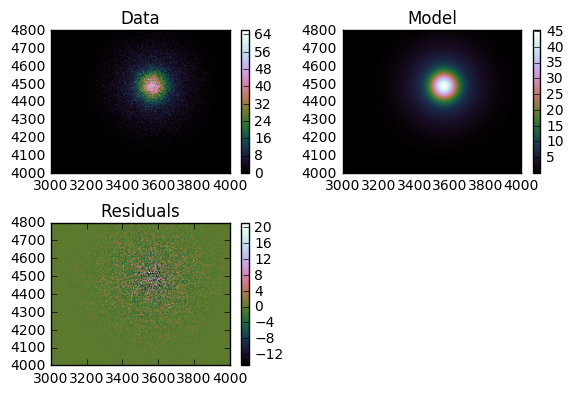

In [8]:
plt.subplot(2, 2, 1)
plt.imshow(image, extent=boundaries)
plt.colorbar()
plt.title('Data')

plt.subplot(2, 2, 2)
plt.imshow(model(x0, x1).reshape(shape), extent=boundaries)
plt.colorbar()
plt.title('Model')

plt.subplot(2, 2, 3)
plt.imshow(residuals, extent=boundaries)
plt.colorbar()
plt.title('Residuals')
plt.tight_layout()

As a rough and quick estimate of the goodness of fit we can check whether the sum of the residuals is close to zero.

In [9]:
residuals.sum()

0.00011785916492712545

## Parameter estimates with MCMC

We now use a Markov Chain Monte Carlo algorithm to estimate the posterior probability distribution of the free model parameters. This computation can take a long time if you are running the notebook on a cloud service, where resources are shared. For this reason, below we set `niter` to 1000, which is too low to get proper posterior distribution sampling, but it should run in a resonable amount of time in the cloud.

If you are running the notebook locally, and you have a reasonably recent system, we suggest you set `niter` to 10000.

Note that in Sherpa, at the time of this writing, you need to manually estimate the parameters covariance before you can call `get_draws`.

In [10]:
niter = 1000
ui.covar()
stats, accept, params = ui.get_draws(1, niter=niter)

Dataset               = 1
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = neldermead
Statistic             = cash
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   model_one.sigma_a      49.7911    -0.531472     0.531472
   model_one.sigma_b      49.6088    -0.517251     0.517251
   model_one.xpos      3561.46    -0.530192     0.530192
   model_one.ypos      4481.47    -0.529137     0.529137
   model_one.ampl      35.3588    -0.454145     0.454145
   model_two.sigma_a      150.519    -0.559748     0.559748
   model_two.sigma_b      150.037    -0.654793     0.654793
   model_two.xpos      3561.28     -0.66665      0.66665
   model_two.ypos      4482.19    -0.714081     0.714081
   model_two.ampl      9.97525    -0.106258     0.106258
Using Priors:
model_one.sigma_a: <function flat at 0x7f1a09a02d08>
model_one.sigma_b: <function flat at 0x7f1a09a02d

To make sure we are comparing apples to apples, let's print the model we started with as *true* with the best fit model. We just need to check that the 0 and 1 components have not been switched. This way we can simply rely on the correspondence of the model parameter names in the following cells.

In [11]:
print(source, "\n\n", model)

(src1 + src2)
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   src1.sigma_a thawed           50  1.17549e-38  3.40282e+38           
   src1.sigma_b thawed           50  1.17549e-38  3.40282e+38           
   src1.xpos    thawed         3561 -3.40282e+38  3.40282e+38           
   src1.ypos    thawed         4482 -3.40282e+38  3.40282e+38           
   src1.theta   frozen            0     -6.28319      6.28319    radians
   src1.ampl    thawed           35 -3.40282e+38  3.40282e+38           
   src2.sigma_a thawed          150  1.17549e-38  3.40282e+38           
   src2.sigma_b thawed          150  1.17549e-38  3.40282e+38           
   src2.xpos    thawed         3561 -3.40282e+38  3.40282e+38           
   src2.ypos    thawed         4482 -3.40282e+38  3.40282e+38           
   src2.theta   frozen            0     -6.28319      6.28319    radians
   src2.ampl    thawed           10 -

Also, in order to produce the representation at the end of this notebook, we need to build an array with the parameter names and an array with the corresponding true values of those parameters. Note that the names of the models are different so we need some manipulation to get the right arrays.

In [12]:
parnames = [p.fullname for p in model.pars if not p.frozen]
mapping = [p.replace('model_one', 'src1') for p in parnames]
mapping = [p.replace('model_two', 'src2') for p in mapping]
parvals = [getattr(source_one, parname.split('.')[-1]).val
           if 'src1' in parname
           else getattr(source_two, parname.split('.')[-1]).val
           for parname in mapping]

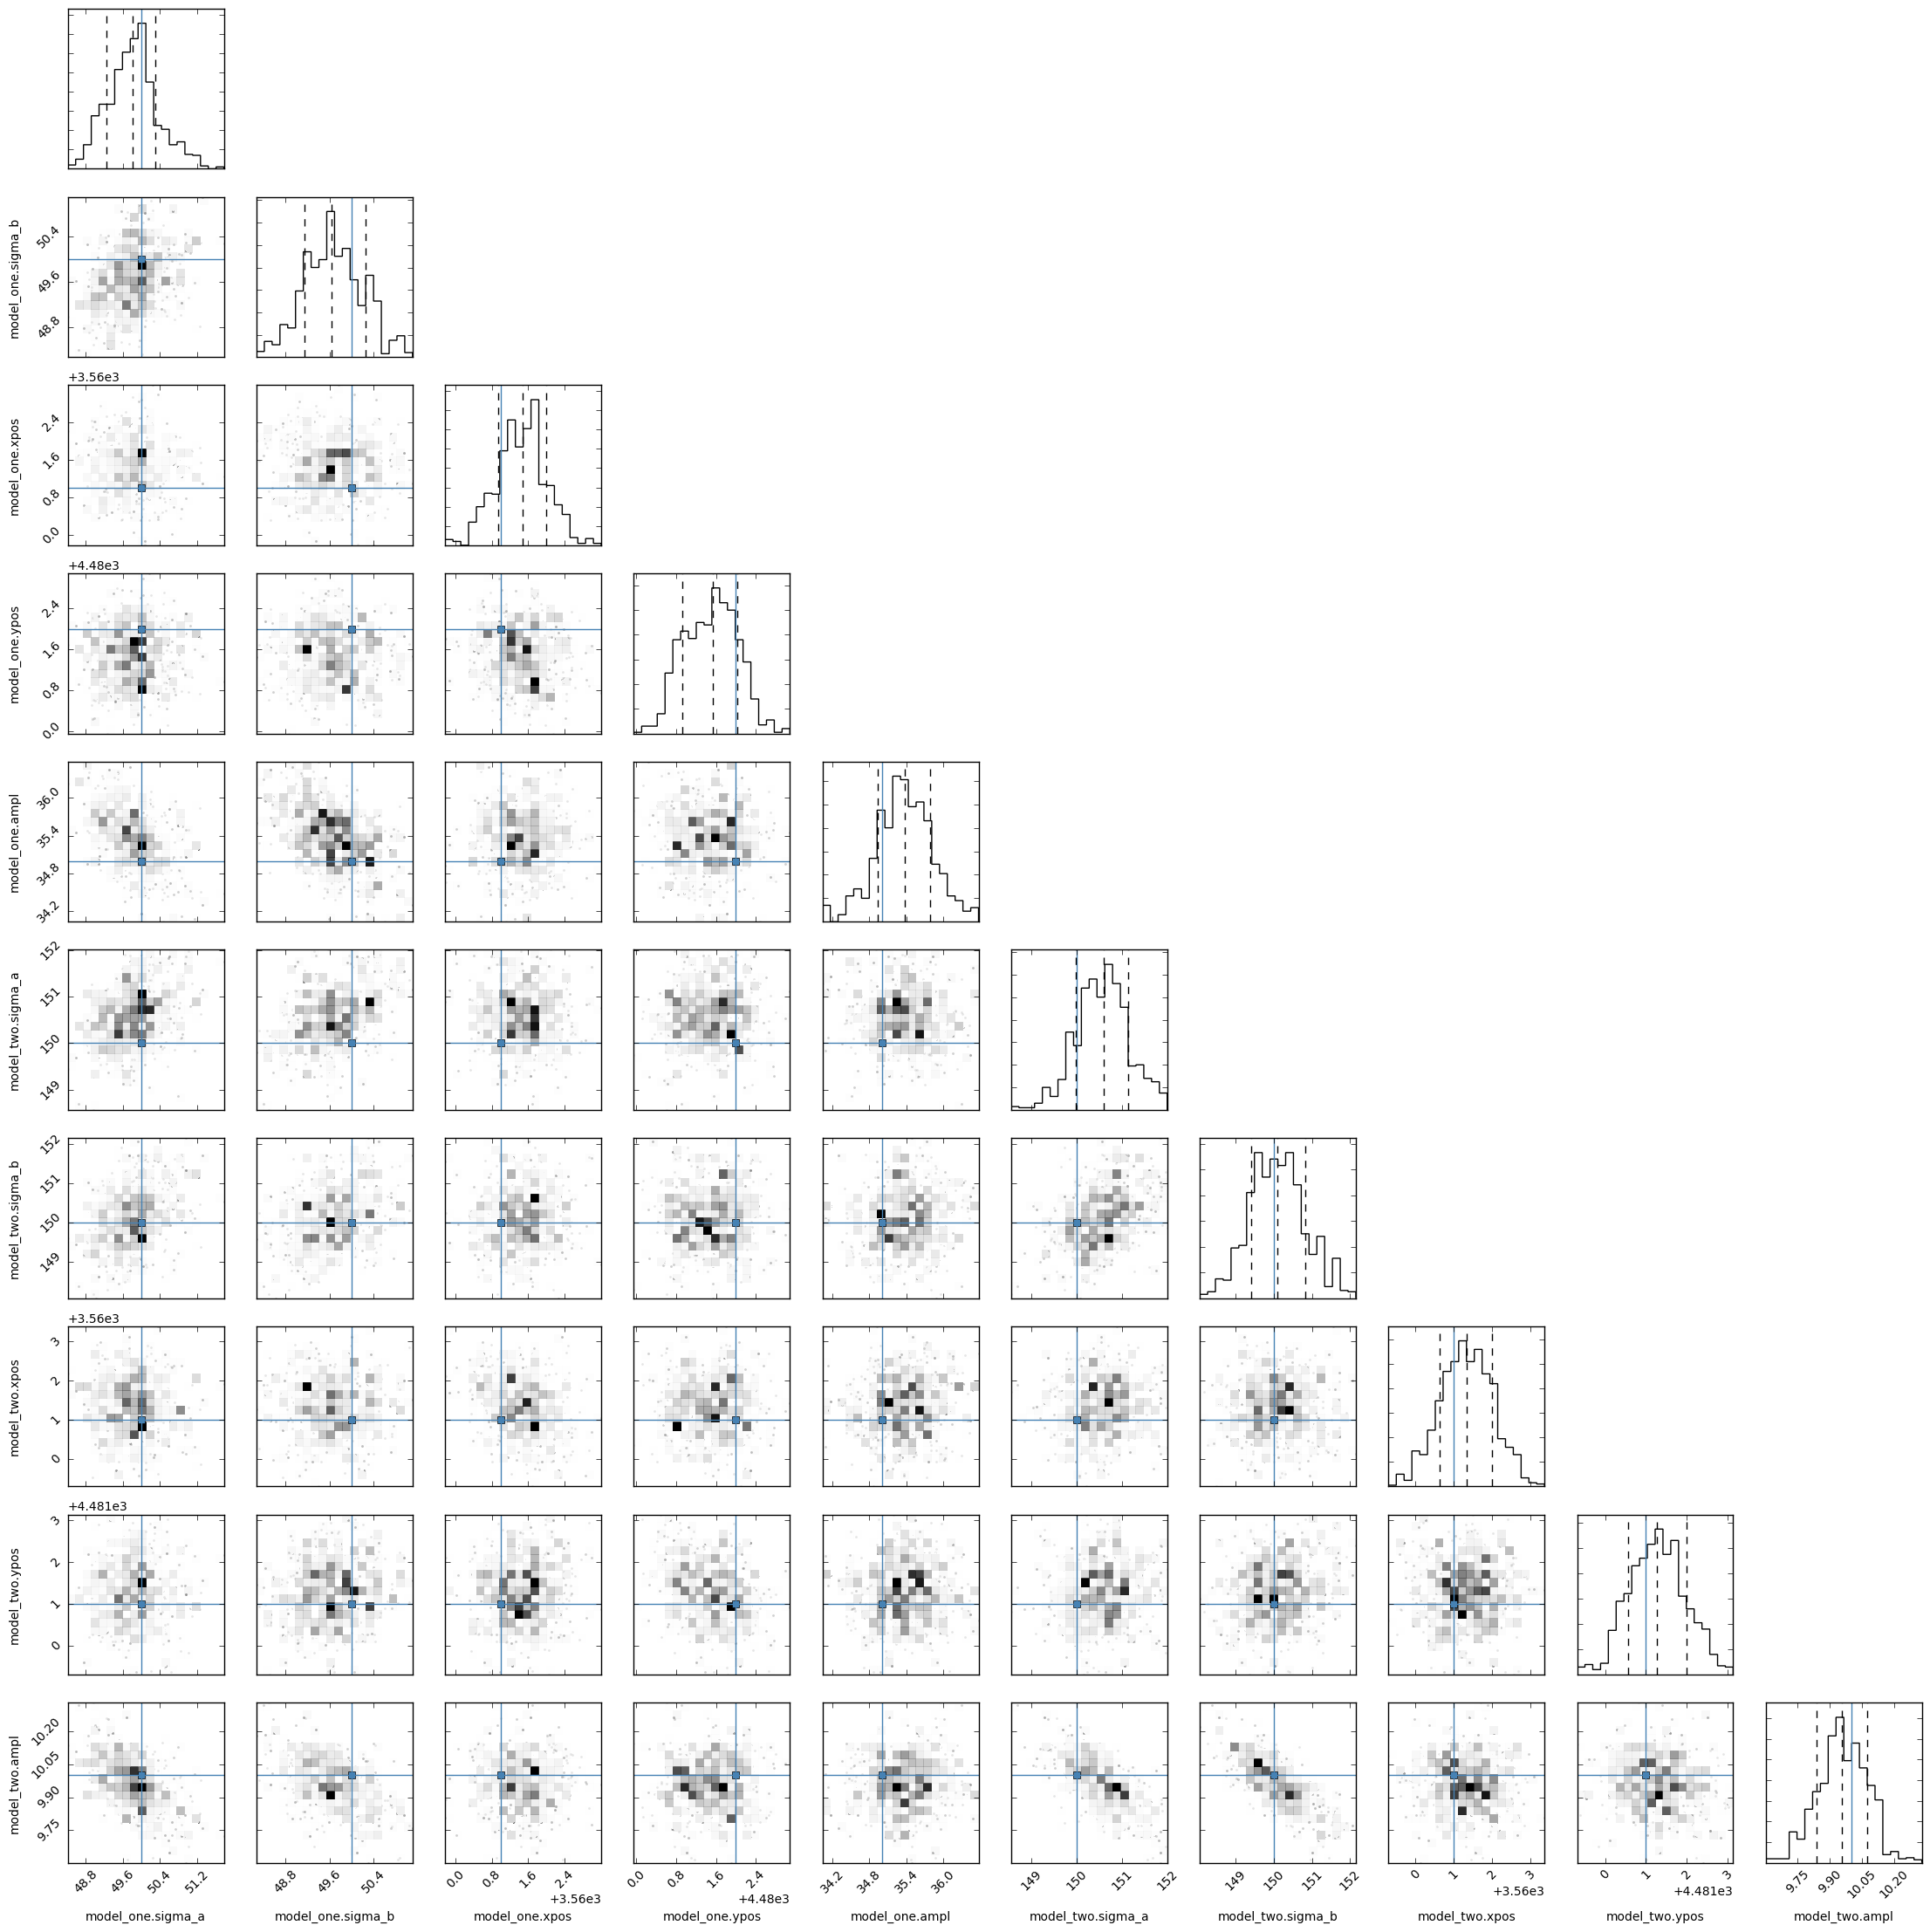

In [13]:
burnin = 0

_ = corner.corner(params[:,burnin:].T, labels=parnames, quantiles=[0.16, 0.5, 0.84], plot_contours=False, truths=parvals)
plt.tight_layout()

The blue lines and dots in the plot above show the true parameter values that we used to simulate the image. The true values fall all within the 1$\sigma$ interval (~68% confidence), assuming the probability distributions are normal.

If you used a low number of iteration, as it is the case by default in this notebook, the distributions will not be very accurate.

Also note the density plots showing the correlation (or lack thereof) between couples of parameters.